# ID. Tutorial name

## Overview

Thanks to the flexibility of the Enoki AD backend, it is possible to encapsulate different rendering algorithms for primal, forward-AD and backward-AD rendering under a single `render()` operator. This solution is very elegant for the users who are interested in differentiating rendering simulation without getting too deep into the implementation details.

A function call to `render` can later be differentiate like any other function (e.g. `ek.sin`) and the gradients will be properly propagated from/to the scene parameters. 

<div class="alert alert-block alert-info">

✔️ **What will you learn?**
    
<ul>
  <li>Important concept learned in this tutorial</li>
  <li>Important take away message</li>
  <li>Things to remember!</li>
</ul>
    
</div>


In [1]:
# Add mitsuba and enoki to PATH (this shouldn't be necessary)
import sys
sys.path.append('../../../build/python')

### Step 1 - initialization

As in the previous tutorials, we will first load a scene and access its parameters using the `traverse` function. We also create a standalone integrator (e.g. `prb`) here, but it is worth noting that we could have used the one provided by the scene as well.

In this tutorial we want to compute an image gradients of the albedo of the red wall of the cornell box, hence we drop all other scene parameters in `params`.

In [2]:
import enoki as ek 
import mitsuba
mitsuba.set_variant('cuda_ad_rgb')

from mitsuba.core import load_file, load_dict
from mitsuba.python.util import traverse

scene = load_file('../scenes/cbox.xml', res=128, max_depth=3)
integrator = load_dict({'type': 'prb', 'max_depth': 2})

params = traverse(scene)

key = 'redwall.bsdf.reflectance.value'
params.keep([key])

2021-12-09 08:10:55 INFO main [xml.cpp:1250] Loading XML file "../scenes/cbox.xml" ..

2021-12-09 08:10:55 INFO main [xml.cpp:1251] Using variant "cuda_ad_rgb"

2021-12-09 08:10:55 INFO main [Scene] Building scene in OptiX ..

2021-12-09 08:10:55 INFO main [Scene] OptiX ready. (took 34ms)

In [3]:
def show_image(img, title):
    from matplotlib import pyplot as plt
    from mitsuba.python.util import convert_to_bitmap
    plt.imshow(convert_to_bitmap(img)); plt.axis('off'); plt.title(title); plt.show()

### Step 2 - primal image rendering

The `mitsuba.python.ad` submodule provide a simple `render` function that can be used to render images.

seed_diff: 1569133783


2021-12-09 08:10:55 INFO main [SamplingIntegrator] Starting render job (128x128, 18 samples)

2021-12-09 08:10:55 INFO main [SamplingIntegrator] Computation graph recorded. (took 15ms)

2021-12-09 08:10:55 INFO main [SamplingIntegrator] Code generation finished. (took 15ms)

2021-12-09 08:10:55 INFO main [SamplingIntegrator] Rendering finished. (took 0ms)

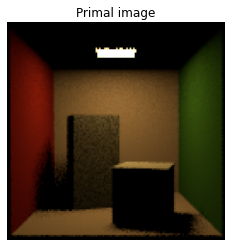

In [4]:
from mitsuba.python.ad import render

ek.enable_grad(params[key])
params.update()

img_primal = render(scene, params, 0, integrator, seed=0, spp=18)
    
show_image(img_primal, 'Primal image')

### Step 3 - forward gradient image rendering

Unlike calling `Scene.render()`, this function is implemented as a [enoki custom differentiable operation](some/link). This means that the when evaluating the forward/reverse-mode derivatives of the resulting image, a custom code will be evaluated rather than relying on automatic differentiation.

Integrators such as `rb`, `prb` implements the adjoint evaluation as another light transport integration as described [here](...).

In the following, `ek.forward` will seemlessly perform an adjoint light transport integration, which is much more efficient than compute a full computation graph for the whole primal simulation.

self.seed: (0, 1569133783), type(self.seed): <class 'tuple'>
self.seed[1]: 1569133783, type(self.seed[1]): <class 'int'>
sensor: 0
seed: 1569133783, type(seed): <class 'int'>
seed: 1569133783, type(seed): <class 'int'>
spp: 18, type(spp): <class 'int'>


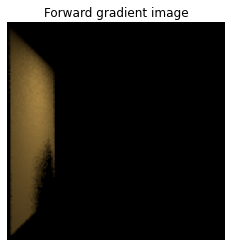

In [5]:
ek.forward(params[key])

img_grad_fwd = ek.grad(img_primal)

show_image(img_grad_fwd, 'Forward gradient image')

### *Reference API*

- [<code>mitsuba.python.ad.render</code>](https://mitsuba2.readthedocs.io/en/latest/generated/core_api.html#mitsuba.core.xml.load_file)